In [2]:
import os
import json
import numpy as np
import textstat
import matplotlib.pyplot as plt

In [3]:
from glob import glob
candidate_folders = range(1000, 1008)
def find_files(folders, max_num_results=1000):
    files = []
    for f in folders:
        files.extend(glob(f'{f}/*.json'))
        if len(files) > max_num_results:
            files = files[:max_num_results]
            break
    return files
def parse_file(file, mode):
    with open(file, 'r') as f:
        data = json.load(f)
    if mode == 'caption':
        captions = [item['caption'] for item in data['annos'] if item['area'] > 32*32]
    elif mode == 'cate':
        captions = [item['category_name'] for item in data['annos']]
    return captions
def load_qwen_results(max_num_results=1000):
    folders = [os.path.join('generated_data_512', f'batch_{i}') for i in candidate_folders]
    files = find_files(folders, max_num_results)
    captions = []
    for f in files:
        captions.append(parse_file(f, 'caption'))
    return captions

def load_blip_results(max_num_results=1000):
    folders = [os.path.join('generated_data_blip', f'batch_{i}') for i in candidate_folders]
    files = find_files(folders, max_num_results)
    captions = []
    for f in files:
        captions.append(parse_file(f, 'caption'))
    return captions

def load_grounding_dino_results(max_num_results=1000):
    folders = [os.path.join('generated_data_512', f'batch_{i}') for i in candidate_folders]
    files = find_files(folders, max_num_results)
    captions = []
    for f in files:
        captions.append(parse_file(f, 'cate'))
    return captions

In [4]:
# length
def get_statis_text_length(res):
    all_length = []
    for r in res:
        if len(r) == 0:
            continue
        all_length.append([len(i.split(' ')) for i in r])
    all_length_micro = [np.mean(i) for i in all_length]
    all_length_macro = sum(all_length, [])
    return {
        'macro': all_length_macro,
        'micro': all_length_micro
    }

# diversity
def get_statis_unique_words(res):
    words_each_sample = []
    for r in res:
        words_in_sample = []
        if len(r) == 0:
            continue
        for i in r:
            words_in_sample.extend(set(i.split(' ')))
        words_each_sample.append(len(set(words_in_sample)))
    return {
        'micro': words_each_sample,
    }

# complexity
def get_statis_complexity(res):
    # res is a list (each sample's sentence) in list (all samples)
    flesch_grade, gunning_fog, coleman_liau = [], [], []
    for r in res:
        if len(r) == 0:
            continue
        # flesch_grade.append([textstat.flesch_kincaid_grade(s) for s in r])
        gunning_fog.append([textstat.gunning_fog(s) for s in r])
        # coleman_liau.append([textstat.coleman_liau_index(s) for s in r])

    # flesch_grade_micro = [np.mean(i) for i in flesch_grade]
    gunning_fog_micro = [np.mean(i) for i in gunning_fog]
    # coleman_liau_micro = [np.mean(i) for i in coleman_liau]

    # flesch_grade_macro = sum(flesch_grade, []) # concat all list in a list
    gunning_fog_macro = sum(gunning_fog, []) # concat all list in a list
    # coleman_liau_macro = sum(coleman_liau, []) # concat all list in a list

    return {
        # 'flesch_grade_micro': flesch_grade_micro,
        'gunning_fog_micro': gunning_fog_micro,
        # 'coleman_liau_micro': coleman_liau_micro,
        # 'flesch_grade_macro': flesch_grade_macro,
        'gunning_fog_macro': gunning_fog_macro,
        # 'coleman_liau_macro': coleman_liau_macro,
    }

In [5]:
gd_res = load_grounding_dino_results(20000)
qwen_res = load_qwen_results(20000)
blip_res = load_blip_results(20000)

In [6]:
metric_res = {
    'text_length': {},
    'unique_words': {},
    'complexity': {}
}
stat_funcs = {
    'text_length': get_statis_text_length, 
    'unique_words': get_statis_unique_words, 
    'complexity': get_statis_complexity
}

In [41]:
metric = 'text_length'
metric_res[metric]['qwen'] = stat_funcs[metric](qwen_res)
metric_res[metric]['blip'] = stat_funcs[metric](blip_res)
metric_res[metric]['gd'] = stat_funcs[metric](gd_res)

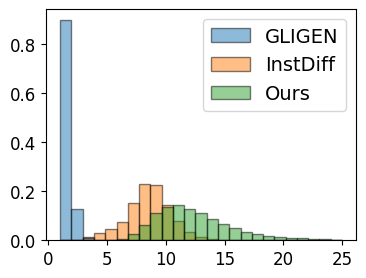

In [42]:
scope = 'macro'
hist_kwargs = {'edgecolor':'black', 'alpha':0.5, 'density':True, 'bins':25, 'range':(1, 25)}
plt.figure(figsize=(4, 3))
plt.hist(metric_res[metric]['gd'][scope], label='GLIGEN', **hist_kwargs)
plt.hist(metric_res[metric]['blip'][scope], label='InstDiff', **hist_kwargs)
plt.hist(metric_res[metric]['qwen'][scope], label='Ours', **hist_kwargs)
# plt.title('Avg Sentence Length (Macro)')
# plt.xlabel('Sentence Length', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.savefig('pdf/macro_text_length.pdf', bbox_inches='tight')

In [ ]:
scope = 'micro'
hist_kwargs = {'edgecolor':'black', 'alpha':0.5, 'density':True, 'bins':30, 'range':(0, 30)}
plt.hist(metric_res[metric]['qwen'][scope], label='Qwen', **hist_kwargs)
plt.hist(metric_res[metric]['blip'][scope], label='BLIP2', **hist_kwargs)
plt.hist(metric_res[metric]['gd'][scope], label='GroundingDINO', **hist_kwargs)
plt.title('Avg Sentence Length (Micro)')
plt.savefig('pdf/micro_text_length.pdf', bbox_inches='tight')
plt.legend()

In [60]:
metric = 'unique_words'
metric_res[metric]['qwen'] = stat_funcs[metric](qwen_res)
metric_res[metric]['blip'] = stat_funcs[metric](blip_res)
metric_res[metric]['gd'] = stat_funcs[metric](gd_res)

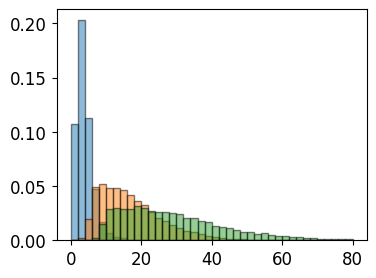

In [61]:
scope = 'micro'
plt.figure(figsize=(4, 3))
hist_kwargs = {'edgecolor':'black', 'alpha':0.5, 'density':True, 'bins':40, 'range':(0, 80)}
plt.hist(metric_res[metric]['gd'][scope], label='GroundingDINO', **hist_kwargs)
plt.hist(metric_res[metric]['blip'][scope], label='BLIP2', **hist_kwargs)
plt.hist(metric_res[metric]['qwen'][scope], label='Qwen', **hist_kwargs)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.legend()
plt.savefig('pdf/unique_words.pdf', bbox_inches='tight')

In [7]:
metric = 'complexity'
metric_res[metric]['qwen'] = stat_funcs[metric](qwen_res)
metric_res[metric]['blip'] = stat_funcs[metric](blip_res)
metric_res[metric]['gd'] = stat_funcs[metric](gd_res)

In [ ]:
scope = 'flesch_grade_micro'
hist_kwargs = {'edgecolor':'black', 'alpha':0.5, 'density':True, 'bins':30, 'range':(0, 30)}
plt.hist(metric_res[metric]['qwen'][scope], label='Qwen', **hist_kwargs)
plt.hist(metric_res[metric]['blip'][scope], label='BLIP2', **hist_kwargs)
plt.hist(metric_res[metric]['gd'][scope], label='GroundingDINO', **hist_kwargs)
plt.title('Flesch Grade Micro')
plt.savefig('pdf/flesch_grade_micro.pdf', bbox_inches='tight')
plt.legend()

In [ ]:
scope = 'flesch_grade_macro'
hist_kwargs = {'edgecolor':'black', 'alpha':0.5, 'density':True, 'bins':30, 'range':(0, 30)}
plt.hist(metric_res[metric]['qwen'][scope], label='Qwen', **hist_kwargs)
plt.hist(metric_res[metric]['blip'][scope], label='BLIP2', **hist_kwargs)
plt.hist(metric_res[metric]['gd'][scope], label='GroundingDINO', **hist_kwargs)
plt.title('Flesch Grade Macro')
plt.savefig('pdf/flesch_grade_macro.pdf', bbox_inches='tight')
plt.legend()

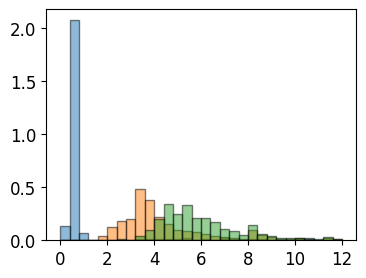

In [8]:
scope = 'gunning_fog_micro'
plt.figure(figsize=(4, 3))
hist_kwargs = {'edgecolor':'black', 'alpha':0.5, 'density':True, 'bins':30, 'range':(0, 12)}
plt.hist(metric_res[metric]['gd'][scope], label='GroundingDINO', **hist_kwargs)
plt.hist(metric_res[metric]['blip'][scope], label='BLIP2', **hist_kwargs)
plt.hist(metric_res[metric]['qwen'][scope], label='Qwen', **hist_kwargs)
# plt.title('Gunning Fog Micro')
# plt.xlabel('Gunning Fog Score', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('pdf/gunning_fog_micro.pdf', bbox_inches='tight')
# plt.legend()

In [ ]:
scope = 'gunning_fog_macro'
hist_kwargs = {'edgecolor':'black', 'alpha':0.5, 'density':True, 'bins':12, 'range':(0, 12)}
plt.hist(metric_res[metric]['qwen'][scope], label='Qwen', **hist_kwargs)
plt.hist(metric_res[metric]['blip'][scope], label='BLIP2', **hist_kwargs)
plt.hist(metric_res[metric]['gd'][scope], label='GroundingDINO', **hist_kwargs)
plt.title('Gunning Fog Macro')
plt.savefig('pdf/gunning_fog_macro.pdf', bbox_inches='tight')
plt.legend()

In [ ]:
scope = 'coleman_liau_micro'
hist_kwargs = {'edgecolor':'black', 'alpha':0.5, 'density':True, 'bins':30, 'range':(0, 12)}
plt.hist(metric_res[metric]['qwen'][scope], label='Qwen', **hist_kwargs)
plt.hist(metric_res[metric]['blip'][scope], label='BLIP2', **hist_kwargs)
plt.hist(metric_res[metric]['gd'][scope], label='GroundingDINO', **hist_kwargs)
plt.title('Coleman Liau Micro')
plt.savefig('pdf/coleman_liau_micro.pdf', bbox_inches='tight')
plt.legend()

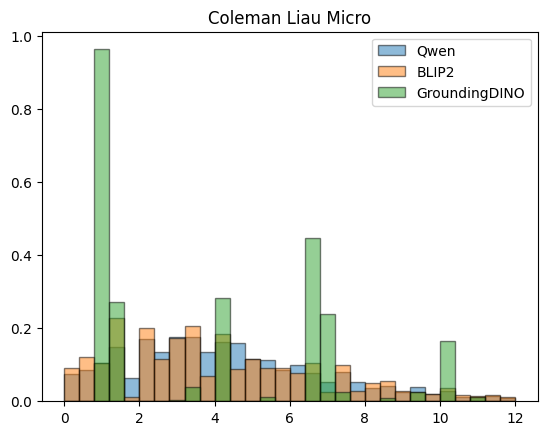

In [21]:
scope = 'coleman_liau_macro'
hist_kwargs = {'edgecolor':'black', 'alpha':0.5, 'density':True, 'bins':30, 'range':(0, 12)}
plt.hist(metric_res[metric]['qwen'][scope], label='Qwen', **hist_kwargs)
plt.hist(metric_res[metric]['blip'][scope], label='BLIP2', **hist_kwargs)
plt.hist(metric_res[metric]['gd'][scope], label='GroundingDINO', **hist_kwargs)
plt.title('Coleman Liau Micro')
plt.savefig('pdf/coleman_liau_macro.pdf', bbox_inches='tight')
plt.legend()